<a href="https://colab.research.google.com/github/danielbauer1979/FI830/blob/main/FI830_HW7_Sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install QuantLib

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm
import numpy as np
import pandas as pd
import QuantLib as ql

In [23]:
# Call option parameters
S0 = 4543
K = 4550
r = 0.0167
T = [0.25,0.5,0.75,1,1.25,1.5]
strikes = [K-200,K-100,K,K+100,K+200]

# Heston model parameters
kappa = 2.75
theta = 0.035
sigma_v = 0.425
v0 = 0.2081*0.2081
rho = -0.46

#MC parameter
N = 1000
delta_t = 1/500

#set similation seed

In [51]:
def MCHeston(S0,K,r,T,kappa,theta,sigma_v,v0,rho,N,delta_t):
  np.random.seed(101)
  C_0 = [0] * N
  for n in range(N):
    d = int((T/delta_t+1))
    v_t = [v0] * d
    St = [S0] * d
    epsilon = multivariate_normal.rvs(mean=[0,0], cov=[[1,rho],[rho,1]], size=d-1)
    for i in range(1,d):
      St[i] = St[i-1] * (1 + r*delta_t + np.sqrt(max(v_t[i-1],0)*delta_t)*epsilon[i-1,0])
      v_t[i] = v_t[i-1] + kappa*(theta-v_t[i-1])*delta_t + sigma_v*np.sqrt(max(v_t[i-1],0)*delta_t)*epsilon[i-1,1]
    C_0[n] = max(St[-1]-K,0)*np.exp(-r*T)
  return(np.average(C_0))


In [52]:
MC_call = np.ndarray(shape=(len(T),len(strikes)))
for i in range(len(T)):
  for j in range(len(strikes)):
    MC_call[i,j] = MCHeston(S0,strikes[j],r,T[i],kappa,theta,sigma_v,v0,rho,N,delta_t)

In [53]:
MC_call_df = pd.DataFrame(data=MC_call,
                          columns=["Strike = %s" % k for k in strikes],
                          index=["T = %.2f" % t for t in T])
MC_call_df

,Strike = 4350,Strike = 4450,Strike = 4550,Strike = 4650,Strike = 4750
T = 0.25,319.238336,252.044692,192.636376,142.294884,101.757787
T = 0.50,402.697889,336.818349,276.851189,224.727366,179.207010
T = 0.75,435.925511,373.103359,315.678372,264.507411,219.537271
T = 1.00,484.111012,421.718347,364.315949,312.244735,265.524106
T = 1.25,536.828568,476.306273,419.846902,367.573997,319.868520
T = 1.50,592.309632,532.387812,476.997440,426.106456,379.846748


In [54]:
#USE QL Code
dividend = 0
today = ql.Date(23,3,2022)
day_count = ql.Actual365Fixed()

maturities = [ql.Date(23,6,2022),ql.Date(23,9,2022),ql.Date(23,12,2022),ql.Date(23,3,2023),ql.Date(23,6,2023),ql.Date(23,9,2023)]

initial_value = ql.QuoteHandle(ql.SimpleQuote(S0))
discount_curve = ql.YieldTermStructureHandle(ql.FlatForward(today,r,day_count))
dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(today,dividend,day_count))
heston_process = ql.HestonProcess(discount_curve,dividend_yield,initial_value,v0,kappa,theta,sigma_v,rho)

In [55]:
ANA_call = np.ndarray(shape=(len(T),len(strikes)))
for i in range(len(T)):
  for j in range(len(strikes)):
    call_payoff = ql.PlainVanillaPayoff(ql.Option.Call, strikes[j]) 
    call_exercise = ql.EuropeanExercise(maturities[i])
    option = ql.VanillaOption(call_payoff, call_exercise)
    engine = ql.AnalyticHestonEngine(ql.HestonModel(heston_process),0.001,1000)
    option.setPricingEngine(engine)
    ANA_call[i,j] = option.NPV()

In [56]:
ANA_call_df = pd.DataFrame(data=ANA_call,
                          columns=["Strike = %s" % k for k in strikes],
                          index=["T = %.2f" % t for t in T])
ANA_call_df

,Strike = 4350,Strike = 4450,Strike = 4550,Strike = 4650,Strike = 4750
T = 0.25,307.596847,241.798572,184.362648,135.970200,96.831419
T = 0.50,380.083188,316.973244,260.094878,209.819920,166.329916
T = 0.75,436.878872,375.371652,319.080499,268.235329,222.956479
T = 1.00,485.958105,425.678485,369.969323,318.981703,272.794060
T = 1.25,531.575780,472.336250,417.193281,366.248649,319.552395
T = 1.50,573.900731,515.552699,460.940208,410.133024,363.162057


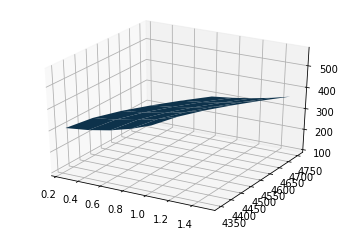

In [57]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Make data

x = np.ndarray(shape=(len(T),len(strikes)))
for i in range(x.shape[0]):
  x[i,:] = T[i]
y = np.ndarray(shape=(len(T),len(strikes)))
for i in range(y.shape[0]):
  y[i,:] = strikes

# Plot the surface
ax.plot_surface(x, y, ANA_call)

plt.show()

In [58]:
BS_call = np.ndarray(shape=(len(T),len(strikes)))
Implied_Vols = np.ndarray(shape=(len(T),len(strikes)))
sigma = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.TARGET(), 0.21, day_count))
BS_process = ql.BlackScholesMertonProcess(initial_value,dividend_yield,discount_curve,sigma)
for i in range(len(T)):
  for j in range(len(strikes)):
    Implied_Vols[i,j] = option.impliedVolatility(ANA_call[i,j], BS_process)
    call_payoff = ql.PlainVanillaPayoff(ql.Option.Call, strikes[j]) 
    call_exercise = ql.EuropeanExercise(maturities[i])
    option = ql.VanillaOption(call_payoff, call_exercise)
    engine = ql.AnalyticEuropeanEngine(BS_process)
    option.setPricingEngine(engine)
    BS_call[i,j] = option.NPV()

In [59]:
BS_call_df = pd.DataFrame(data=BS_call,
                          columns=["Strike = %s" % k for k in strikes],
                          index=["T = %.2f" % t for t in T])
BS_call_df

,Strike = 4350,Strike = 4450,Strike = 4550,Strike = 4650,Strike = 4750
T = 0.25,310.879459,249.720303,196.855999,152.241070,115.488190
T = 0.50,393.604139,336.304543,284.912874,239.340163,199.379100
T = 0.75,459.596291,404.203131,353.640538,307.820480,266.591993
T = 1.00,516.290723,462.154765,412.202171,366.350109,324.475845
T = 1.25,568.419699,515.256571,465.820465,420.033970,377.792127
T = 1.50,616.274183,563.901883,514.918108,469.250292,426.805660


In [60]:
Implied_Vols_df = pd.DataFrame(data=Implied_Vols,
                          columns=["Strike = %s" % k for k in strikes],
                          index=["T = %.2f" % t for t in T])
Implied_Vols_df

,Strike = 4350,Strike = 4450,Strike = 4550,Strike = 4650,Strike = 4750
T = 0.25,0.156344,0.116673,0.133969,0.142911,0.148205
T = 0.50,0.505011,0.143096,0.148138,0.151235,0.153178
T = 0.75,0.395208,0.151013,0.153539,0.155101,0.156047
T = 1.00,0.349552,0.155305,0.156866,0.157772,0.158296
T = 1.25,0.324364,0.158302,0.159318,0.159932,0.160240
T = 1.50,0.306920,0.160564,0.161300,0.161724,0.161913


**Delta & Vega**

In [69]:
delta_S0 = 0.01
delta_v0 = 0.0001 * 0.0001

Delta_MC = (MCHeston(S0+delta_S0,strikes[2],r,T[3],kappa,theta,sigma_v,v0,rho,N,delta_t)-MC_call[3,2])/delta_S0
print('Monte Carlo Delta:')
print(Delta_MC)

initial_value = ql.QuoteHandle(ql.SimpleQuote(S0+delta_S0))
heston_process = ql.HestonProcess(discount_curve,dividend_yield,initial_value,v0,kappa,theta,sigma_v,rho)
call_payoff = ql.PlainVanillaPayoff(ql.Option.Call, strikes[2]) 
call_exercise = ql.EuropeanExercise(maturities[3])
option = ql.VanillaOption(call_payoff, call_exercise)
engine = ql.AnalyticHestonEngine(ql.HestonModel(heston_process),0.001,1000)
option.setPricingEngine(engine)
Delta_ANA = (option.NPV() - ANA_call[3,2])/delta_S0
print('Analytical Delta:')
print(Delta_ANA)

Vega_MC = (MCHeston(S0,strikes[2],r,T[3],kappa,theta,sigma_v,v0 + delta_v0,rho,N,delta_t)-MC_call[3,2])/delta_v0
print('Monte Carlo Vega:')
print(Vega_MC)

initial_value = ql.QuoteHandle(ql.SimpleQuote(S0))
heston_process = ql.HestonProcess(discount_curve,dividend_yield,initial_value,v0 + delta_v0,kappa,theta,sigma_v,rho)
call_payoff = ql.PlainVanillaPayoff(ql.Option.Call, strikes[2]) 
call_exercise = ql.EuropeanExercise(maturities[3])
option = ql.VanillaOption(call_payoff, call_exercise)
engine = ql.AnalyticHestonEngine(ql.HestonModel(heston_process),0.001,1000)
option.setPricingEngine(engine)
Vega_ANA = (option.NPV() - ANA_call[3,2])/delta_v0
print('Analytical Vega:')
print(Vega_ANA)

Monte Carlo Delta:
0.6337369530058368
Analytical Delta:
0.6159404370009725
Monte Carlo Vega:
1515.305069688111
Analytical Vega:
1535.2449281635927
